# Clustering

- Hard: 각 샘플에 대해 가장 가까운 클러스터 선택
- Soft: 클러스터마다 샘플에 클러스터 점수 부여

In [1]:
import warnings, platform
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package load

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import fetch_openml

from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

## Distance Metrics
- Clustering의 기준이 되는 지표들
- Numeric
    - 수학적: Euclidian(제곱), Manhattan(절대값), Chebyshev(각 dimension의 Manhattan 거리 중 최대값), Minkowski(n제곱), Canberra(가중 절대값), Cosine(벡터 방향각)
    - 통계적: Standardized(표본분산), Mahalanobis(표본 공분산)
- Categorical
    - Dice (2*교집합/A + B 영역), Jaccard(교집합/합집합 영역), Hamming (같은 위치에서, 서로 다른 원소의 개수)
- Mixed: Gower

In [5]:
from scipy.spatial import distance

### (1) Numeric

In [6]:
a = np.array((1, 2, 3, 4))
b = np.array((1, 1, 1, 3))

In [7]:
### Euclidian
distance.euclidean(a, b)

2.449489742783178

In [8]:
### Manhattan
distance.cityblock(a, b)

4

In [9]:
### Chebyshev
distance.chebyshev(a, b)

2

In [10]:
### Canberra
distance.canberra(a, b)

0.976190476190476

In [11]:
### Minkowski
distance.minkowski(a, b)

2.449489742783178

In [12]:
### Cosine
distance.cosine(a, b)

0.05131670194948623

In [13]:
### Correlation
# 1 - pd.DataFrame([a, b]).T.corr()[1][0]
# 선형 관계 correlation의 역수
distance.correlation(a, b)

0.2254033307585166

In [14]:
### Standardized
iv = [[0.5, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0.5, 0], [0, 0, 0, 1]] # inverse of sample variance(diag) matrix
distance.mahalanobis(a, b, iv)

2.0

In [15]:
### Mahalanobis
iv = [[1, 0.5, 0.5, 1], [0.5, 1, 0.5, 1], [0.5, 0.5, 1, 1], [1, 1, 1, 1]] # inverse of cov matrix
distance.mahalanobis(a, b, iv)

3.7416573867739413

### (2) Categorical

In [16]:
a = np.array((1, 0, 1, 1, 1))
b = np.array((1, 0, 0, 0, 1))

In [17]:
### Dice
distance.dice(a, b)

0.3333333333333333

In [18]:
### Jaccard
distance.jaccard(a, b)

0.5

In [19]:
### Hamming
distance.hamming(a, b)

0.4

### (3) Oridinal

In [20]:
a = np.array((1, 2, 3, 4))
b = np.array((1, 3, 4, 8))

In [21]:
### Rank Correlation distance
# Spearman 상관계수의 역수
1 - pd.DataFrame([a, b]).T.corr(method='spearman')[1][0]

0.0

### (4) Mixed
- Gower: 수치형+범주형 모든 변수가 0-1 사이에 오도록 함
    - 수치형은 Manhattan, 범주형은 다르면 1, 같으면 0

In [22]:
# !pip install gower
import gower

In [23]:
loan_data = pd.read_csv("./Practical_Statictics/data/loan_data.csv.gz")
defaults = loan_data.loc[loan_data['outcome']=='default', ]

x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]

In [24]:
gower.gower_matrix(x)

array([[0.        , 0.62204784, 0.6863877 , 0.632904  , 0.37727892],
       [0.62204784, 0.        , 0.8143398 , 0.7608561 , 0.5389727 ],
       [0.6863877 , 0.8143398 , 0.        , 0.43070832, 0.30910876],
       [0.632904  , 0.7608561 , 0.43070832, 0.        , 0.505625  ],
       [0.37727892, 0.5389727 , 0.30910876, 0.505625  , 0.        ]],
      dtype=float32)

## Hierarchical Clustering
- 개체(군집) 간 거리(유사성) 기반 분석

### (1) Agglomerative Clustering
- 연결법
    - 최단, 최장, 평균: 지역적 최적화
    - 중심, 와드: 군집의 크기에 가중을 둘 수 있음
- methods: single, complete, average, weighted, centroid, median, ward

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [26]:
usarrests = pd.read_csv('./r_csv/datasets/USArrests.csv', index_col='Unnamed: 0')
usarrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [27]:
label_list = usarrests.index

#### Single Linkage Method
- 최단연결법
- 군집 별 관측치 거리의 최소값으로 거리 측정
- 군집의 객체 수가 비슷하지 않을 수 있음

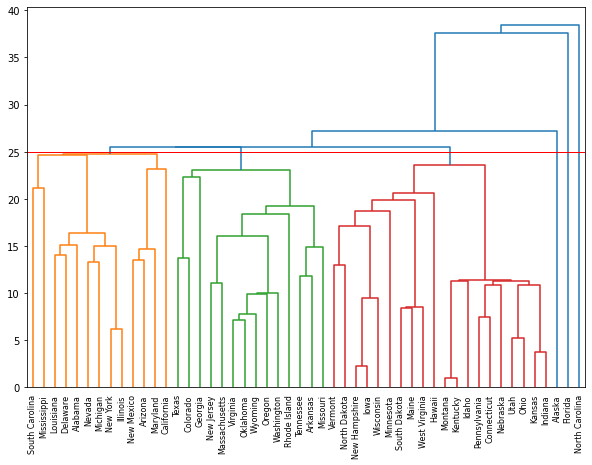

In [28]:
single = linkage(usarrests.iloc[:, 1::], metric='euclidean', method='single')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(single,
            orientation='top',
            labels=label_list,
            distance_sort='descending',
            color_threshold=25,# 군집의 수를 설정하는 Height 값 설정
            show_leaf_counts=True)

plt.axhline(y=25, color='r', linewidth=1) # Height 값에 따라 선을 그어 적절한 군집 수 설정
plt.show()

#### Ward Linkage Method
- 최단연결법의 단점 보완. 군집 내 오차(SSE)에 기반한 거리 측정
- 상대적으로 계산량이 많으나, 해석력이 높음

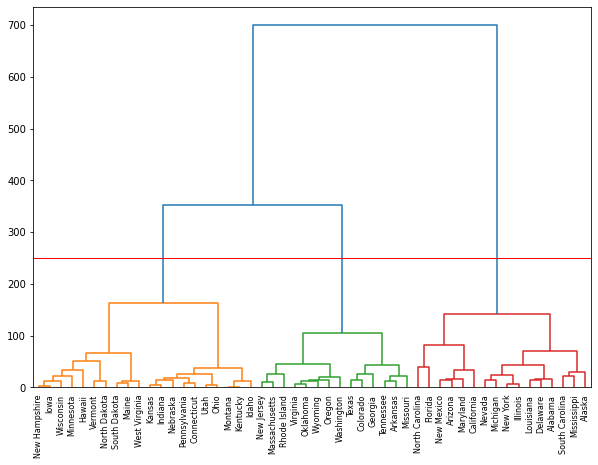

In [29]:
ward = linkage(usarrests.iloc[:, 1::], metric='euclidean', method='ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(ward,
            orientation='top',
            labels=label_list,
            distance_sort='descending',
            color_threshold=250,
            show_leaf_counts=True)
plt.axhline(y=250, color='r', linewidth=1)  # Height 값에 따라 선을 그어 적절한 군집 수 설정
plt.show()


In [30]:
# state마다 어떤 군집에 설정되었는지 확인
assignments = fcluster(ward, 250, 'distance')
assignments

array([1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 2, 1,
       3, 1, 2, 3, 3, 1, 3, 2, 1, 1, 1, 3, 3, 2, 2, 3, 2, 1, 3, 2, 2, 3,
       3, 2, 2, 3, 3, 2], dtype=int32)

In [31]:
usarrests['cluster'] = assignments
usarrests.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
1,11.812500,272.562500,68.312500,28.375000
2,8.214286,173.285714,70.642857,22.842857
3,4.270000,87.550000,59.750000,14.390000


#### Complete Linkage Method
- Scikit-learn 사용했으나, Scipy 사용도 위와 마찬가지로 가능

In [32]:
from sklearn.cluster import AgglomerativeClustering

In [33]:
import numpy as np

In [34]:
### Agglomerative with Scikit-learn
x = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(x)

In [35]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [36]:
agg.labels_

array([1, 1, 0, 0])

In [37]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

#### Average Linkage Method & Gower distance

In [38]:
import gower

In [39]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
x

,dti,payment_inc_ratio,home_,purpose_
0,1.00,2.39320,RENT,major_purchase
1,5.55,4.57170,OWN,small_business
2,18.08,9.71600,RENT,other
3,10.08,12.21520,RENT,debt_consolidation
4,7.06,3.90888,RENT,other


In [40]:
dist_matrix = gower.gower_matrix(x)
model_average = AgglomerativeClustering(n_clusters=2, linkage='average', affinity='precomputed')
clusters_average = model_average.fit_predict(dist_matrix)
clusters_average

array([0, 1, 0, 0, 0])

### (2) HDBSCAN
- Hierachical DBSCAN
- 계층적 구조 및 Local density에 대한 정보 반영
- HDBDCAN Steps
    - Transform the space according to the density/sparsity.
    - Build the minimum spanning tree of the distance weighted graph.
    - Construct a cluster hierarchy of connected components.
    - Condense the cluster hierarchy based on minimum cluster size.
    - Extract the stable clusters from the condensed tree.

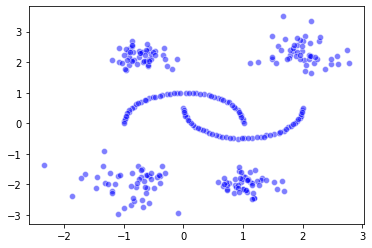

In [41]:
num = 100
moons, _ = make_moons(n_samples=num, noise=0.01)
blobs, _ = make_blobs(n_samples=num, centers=[(-0.75,2.25), (1.0, -2.0)], cluster_std=0.25)
blobs2, _ = make_blobs(n_samples=num, centers=[(2,2.25), (-1, -2.0)], cluster_std=0.4)
test_data = np.vstack([moons, blobs,blobs2])
sns.scatterplot(test_data.T[0], test_data.T[1], color='blue', alpha=0.5, linewidths=0)
plt.show()

In [42]:
# !pip install hdbscan
import hdbscan

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True) # min_size는 없을 경우 min_cluster_size로 자동 생성
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

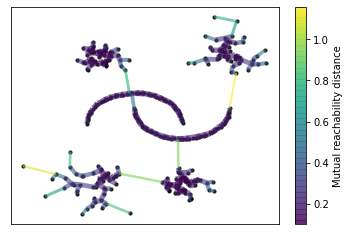

In [44]:
# Cluster hierachy tree 
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=10, edge_linewidth=2)
plt.show()

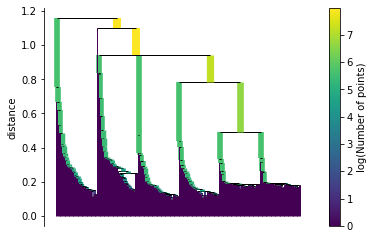

In [45]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True) # dendrogram
plt.show()

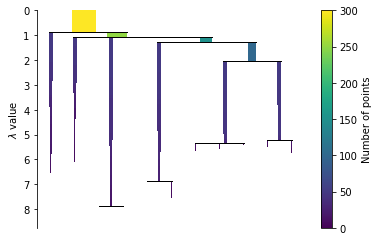

In [46]:
# 일정 distance 미만의 데이터(minimum size 미만의 클러스터)를 noise로 처리
clusterer.condensed_tree_.plot()
plt.show()

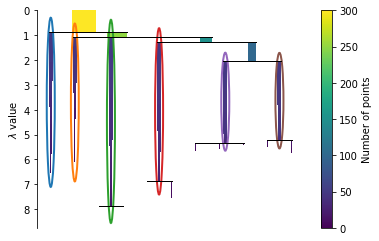

In [47]:
# 안정적인 클러스터 추출 (오래 살아남은 클러스터)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

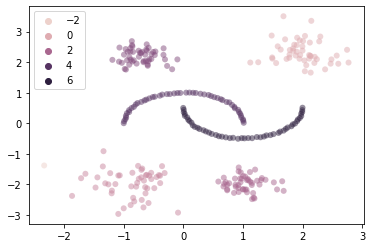

In [48]:
sns.scatterplot(x=test_data.T[0], y=test_data.T[1], hue=clusterer.labels_, linewidth=0, alpha=0.5)
plt.show()

## Non-hierarchical Clustering

### (1) K-Means
- 군집 개수만큼 초기값을 지정하고 초기 군집을 형성한 후, 평균을 재계산하여 값 갱신
- 초기 센트로이드는 K-means++ 알고리즘이 기본값 (random보다 좋음)
- Scaling 필요
- 이상치 영향을 많이 받을 수 있고, 볼록한 군집 형태가 아니면 성능이 떨어짐
- 변수가 많은 경우 정확도가 떨어짐 (PCA 고려)
- Inertia
    - 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리
    - 랜덤 초기화를 하여 여러 번 알고리즘을 실행한 다음, 이너셔가 낮은 모델을 선택하게 됨
- 응용 분야: 변수 추가, Semi-supervised learning

In [49]:
iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['Class'] = load_iris().target

In [50]:
x = iris.drop('Class', axis=1)
x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [51]:
from sklearn.cluster import KMeans

In [52]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(x)

KMeans(n_clusters=3, random_state=1)

In [53]:
# inertia
km.inertia_

78.851441426146

In [54]:
# score는 음수 출력 (클 수록 좋은 것 규칙)
km.score(x)

-78.85144142614602

In [55]:
# labels
km.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

In [56]:
# 할당된 군집을 iris 데이터에 추가
new_labels = km.labels_
iris['cluster'] = new_labels
iris.drop('Class', axis=1).groupby(['cluster']).mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
cluster,,,,
0,5.901613,2.748387,4.393548,1.433871
1,5.006000,3.428000,1.462000,0.246000
2,6.850000,3.073684,5.742105,2.071053


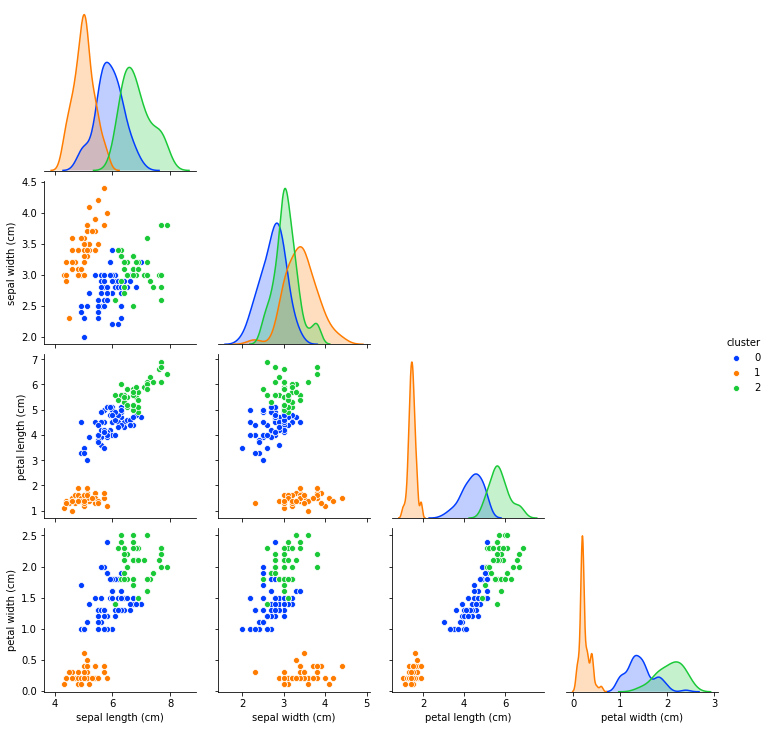

In [57]:
### k-means 결과 시각화
sns.pairplot(iris.drop('Class', axis=1), diag_kind='kde', hue="cluster", corner=True, palette='bright')
plt.show()

In [58]:
### class와 cluster 비교
# label은 알고리즘이 결정하므로 달라질 수 잇음
iris.groupby('Class')['cluster'].value_counts()

Class  cluster
0      1          50
1      0          48
       2           2
2      2          36
       0          14
Name: cluster, dtype: int64

In [59]:
### centroids
centroids = km.cluster_centers_
centroids

array([[5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

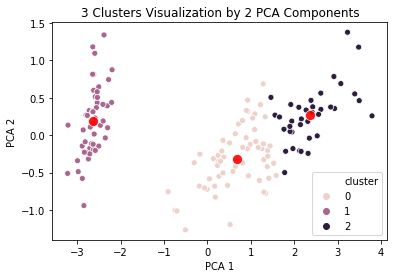

In [60]:
### PCA로 2차원 시각화
x = iris.drop(['Class', 'cluster'], axis=1)

try:
    x = x.drop(['pca_x', 'pca_y'], axis=1)
except KeyError:
    pass

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x)
centroids_transformed = pca.transform(centroids)

iris['pca_x'] = pca_transformed[:, 0]
iris['pca_y'] = pca_transformed[:, 1]

sns.scatterplot(x=iris['pca_x'], y=iris['pca_y'], hue=iris.cluster)
sns.scatterplot(x=centroids_transformed[:, 0], y=centroids_transformed[:, 1], s=100, linewidths=8, color='red', alpha=0.9)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

In [61]:
### new data predict
x_new = np.array([[4.2, 2, 0, 2], [3, 2, 1, 2], [3, 3, 3, 3], [3, 2.5, 1, 4]])
km.predict(x_new)

array([1, 1, 0, 1], dtype=int32)

In [62]:
### n_init 지정 (default 10)
kmeans_rnd_10_inits = KMeans(n_clusters=3, n_init=5, init="random", algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(x)

KMeans(algorithm='full', init='random', n_clusters=3, n_init=5, random_state=2)

In [63]:
### elkan 알고리즘은 더 빠르지만, 희소 행렬은 지원하지 않음
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(x)

8.92 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [64]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(x)

13.9 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


#### Best K
- Elbow: SSE(inertia)가 급격하게 줄거나, 기울기가 소실되는 구간 판단
- Calinski_harabasz: 높을수록 성능이 좋음
- Silhouette score, silhouette plot: 샘플 개수 실루엣 계수 종합적으로 판단
    - 각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지 판단
    - (b-a)/max(a, b). a는 클러스터 내 다른 샘플까지의 평균 거리, b는 가장 가까운 클러스터까지 평균 거리

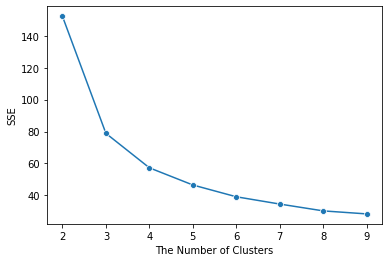

[152.34795176035797, 78.851441426146, 57.228473214285714, 46.44618205128203, 39.03998724608724, 34.46949589883803, 30.186555194805198, 28.28937085137087]


In [65]:
### elbow plot
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(x) for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

sns.lineplot(range(2, 10), inertias, marker='o')
plt.xlabel('The Number of Clusters')
plt.ylabel('SSE')
plt.show()
    
print(inertias)

In [66]:
from sklearn.metrics import calinski_harabasz_score

In [67]:
### Calinski harabasz
# 가장 높은 값 선택
for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(x)
    print(f'calinski_harabasz for k={k}: {calinski_harabasz_score(x, kmeans_model.labels_)}')

calinski_harabasz for k=2: 513.9245459802768
calinski_harabasz for k=3: 561.62775662962
calinski_harabasz for k=4: 530.4871420421675
calinski_harabasz for k=5: 495.54148767768777
calinski_harabasz for k=6: 473.5154538824768
calinski_harabasz for k=7: 443.84523107907245
calinski_harabasz for k=8: 440.59767319067873
calinski_harabasz for k=9: 407.0468400265113


In [68]:
from sklearn.metrics import silhouette_score

In [69]:
### Silhouette score
# 전체 평균이 1에 가까울수록 좋음
# 군집의 스코어 편차가 작은 것이 좋음
silhouette_score(x, km.labels_)

0.5528190123564095

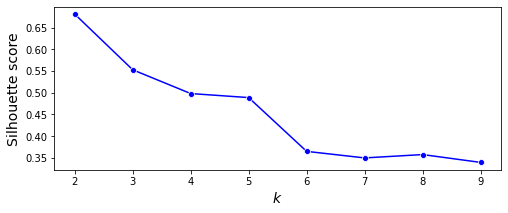

In [70]:
silhouette_scores = [silhouette_score(x, model.labels_) for model in kmeans_per_k]

plt.figure(figsize=(8, 3))
sns.lineplot(range(2, 10), silhouette_scores, color='blue', marker="o")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [71]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

In [72]:
# iris 의 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(x, km.labels_)

# irisDF에 실루엣 계수 컬럼 추가
iris['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함
average_score = silhouette_score(x.iloc[:, :4], iris['cluster'])
print('Silhouette Analysis Score: {0:.3f}'.format(average_score))

Silhouette Analysis Score: 0.553


In [73]:
iris.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

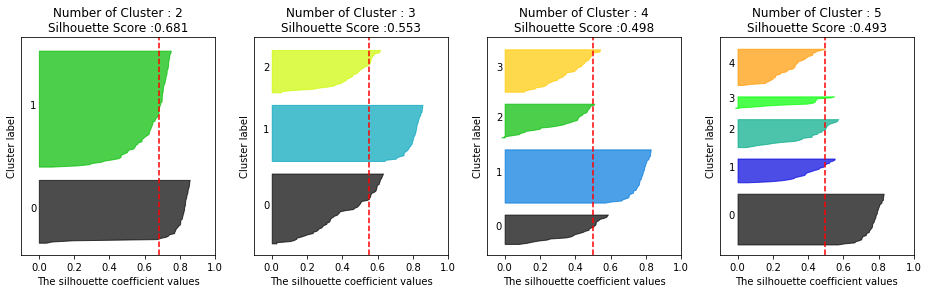

In [74]:
### silhouette diagram
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성

cluster_lists = [2, 3, 4, 5]
n_cols = len(cluster_lists)
fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

# 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
for ind, n_cluster in enumerate(cluster_lists):
    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
    clusterer = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_labels = clusterer.fit_predict(x)
        
    sil_avg = silhouette_score(x, cluster_labels)
    sil_values = silhouette_samples(x, cluster_labels)
        
    y_lower = 10
    axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\nSilhouette Score :' + str(round(sil_avg,3)))
    axs[ind].set_xlabel("The silhouette coefficient values")
    axs[ind].set_ylabel("Cluster label")
    axs[ind].set_xlim([-0.1, 1])
    axs[ind].set_ylim([0, len(x) + (n_cluster + 1) * 10])
    axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
    axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
    for i in range(n_cluster):
        ith_cluster_sil_values = sil_values[cluster_labels==i]
        ith_cluster_sil_values.sort()
            
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
            
        color = cm.nipy_spectral(float(i) / n_cluster)
        axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
        axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
            
    axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

#### K-means Pipeline

In [75]:
### wine data
wine_load = load_wine()
wine = pd.DataFrame(wine_load.data, columns=wine_load.feature_names)
wine['Class'] = wine_load.target
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [76]:
x = wine.drop('Class', axis=1)
y = wine['Class']

In [77]:
### Scaling
scaler = StandardScaler()
scaled = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled, columns=[x.columns])

In [78]:
### Calinski harabasz
# 가장 높은 값 선택
for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(scaled)
    print(f'calinski_harabasz for k={k}: {calinski_harabasz_score(scaled, kmeans_model.labels_)}')

calinski_harabasz for k=2: 69.48646422404195
calinski_harabasz for k=3: 70.9400080031512
calinski_harabasz for k=4: 56.17394712859297
calinski_harabasz for k=5: 46.92280591119328
calinski_harabasz for k=6: 41.70374736238613
calinski_harabasz for k=7: 38.12878130797722
calinski_harabasz for k=8: 35.736913455820364
calinski_harabasz for k=9: 33.14415210830037


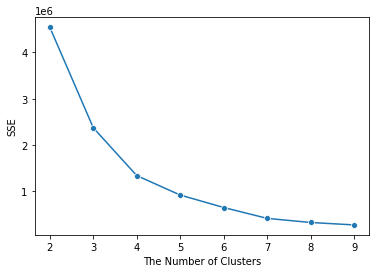

[4543749.614531863, 2370689.6867829696, 1337029.4929415905, 916379.1871539167, 647326.0020260852, 412303.82825080125, 323223.2470542671, 270954.92924153735]


In [79]:
### elbow plot
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(x) for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

sns.lineplot(range(2, 10), inertias, marker='o')
plt.xlabel('The Number of Clusters')
plt.ylabel('SSE')
plt.show()
    
print(inertias)

In [80]:
# 최적의 k로  K-Means 군집화 실행
km = KMeans(n_clusters=3, random_state=1)
km.fit(x)

# 할당된 군집을 데이터에 추가
new_labels = km.labels_
wine['cluster'] = new_labels

wine.groupby(['cluster']).mean()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
cluster,,,,,,,,,,,,,,
0,13.804468,1.883404,2.426170,17.023404,105.510638,2.867234,3.014255,0.285319,1.910426,5.702553,1.078298,3.114043,1195.148936,0.021277
1,12.516667,2.494203,2.288551,20.823188,92.347826,2.070725,1.758406,0.390145,1.451884,4.086957,0.941159,2.490725,458.231884,1.275362
2,12.929839,2.504032,2.408065,19.890323,103.596774,2.111129,1.584032,0.388387,1.503387,5.650323,0.883968,2.365484,728.338710,1.258065


In [81]:
confusion_matrix(y, wine['cluster'])

array([[46,  0, 13],
       [ 1, 50, 20],
       [ 0, 19, 29]])

#### Cohesion, Separation
- Cohesion(응집도): 클러스터 내의 모든 거리 가중치의 합. 클러스터 내의 객체들이 밀집해있는 정도를 측정함(=SSE, inertia)
- Separation(분리도): 클러스터 외부 객체 간의 모든 거리 가중치의 합으로, 클러스터 간 잘 분리되어 있는 정도를 측정함. 각 클러스터의 중심점과의 pairwise 거리 최소값으로 측정

In [82]:
from sklearn.metrics import pairwise_distances_argmin_min

In [83]:
d = pairwise_distances_argmin_min(km.cluster_centers_, scaled_df)[1]

print(f'군집결과의 응집도는 {round(km.inertia_, 3)}, 분리도는 {round(sum(d) / len(d), 3)}')

군집결과의 응집도는 2370689.687, 분리도는 798.381


#### Minibatch K-means

In [84]:
from sklearn.cluster import MiniBatchKMeans

In [85]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(x)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [86]:
minibatch_kmeans.inertia_

940729.7475238508

In [87]:
### partial fit
# batch load
def load_next_batch(batch_size):
    return np.array(x)[np.random.choice(len(np.array(x)), batch_size, replace=False)]

k = 5
n_init = 10
n_iterations = 100
batch_size = 20
init_size = 50  # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10

best_kmeans = None
np.random.seed(42)
for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    x_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(x_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        x_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(x_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans
        
best_kmeans.score(x)

-920589.4968601471

In [88]:
from timeit import timeit

In [89]:
# 시간 비교
times = np.empty((20, 2))
inertias = np.empty((20, 2))
for k in range(1, 21):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 20), end="")
    times[k-1, 0] = timeit("kmeans_.fit(x)", number=3, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(x)", number=3, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

20/20

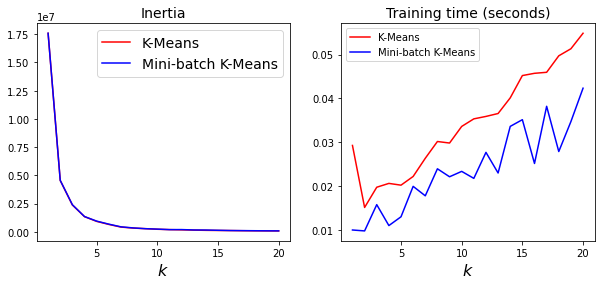

In [90]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.lineplot(x=range(1, 21), y=inertias[:, 0], color="red", linestyle="dashed", label="K-Means")
sns.lineplot(x=range(1, 21), y=inertias[:, 1], color="blue", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(122)
sns.lineplot(x=range(1, 21), y=times[:, 0], color="red", linestyle="dashed", label="K-Means")
sns.lineplot(x=range(1, 21), y=times[:, 1], color="blue", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.show()

### (3) K-medoids
- 평균 대신 중앙값 사용

In [91]:
x = iris.drop(['Class', 'cluster'], axis=1)

In [92]:
# !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

In [93]:
kme = KMedoids(n_clusters=3, metric='euclidean', random_state=1)
kme.fit(x)

# 할당된 군집을 iris 데이터에 추가
new_labels = kme.labels_
iris['cluster_kme'] = new_labels

In [94]:
confusion_matrix(iris['cluster'], iris['cluster_kme']) # 군집이 조금 다르게 이루어졌음

array([[56,  0,  6],
       [ 0, 50,  0],
       [ 0,  0, 38]])

### (4) Mean Shift
- 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킴
- 데이터의 분포를 이용하여 군집 중심을 찾음
- KDE (Kernel Density Estimation) 이용
    - 적절한 KDE bandwidth(h) 제공이 중요
    - 작을수록 좁고 뾰족한 KDE이며, overfitting 확률이 높음

In [95]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [96]:
x, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(x)
print('cluster labels 유형:', np.unique(cluster_labels))

meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(x)
print('cluster labels 유형:', np.unique(cluster_labels))

bandwidth = estimate_bandwidth(x)
print('bandwidth 값:', round(bandwidth,3))

cluster labels 유형: [ 0  1  2  3  4  5  6  7  8  9 10]
cluster labels 유형: [0 1 2 3]
bandwidth 값: 1.754


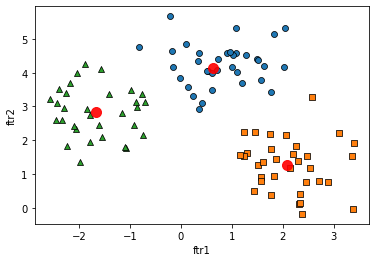

In [97]:
cluster = pd.DataFrame(data=x, columns=['ftr1', 'ftr2'])
cluster['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(x)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster['meanshift_label']  = meanshift.fit_predict(x)
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster['meanshift_label'])
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = cluster[cluster['meanshift_label']==label]
    center_x_y = centers[label]
    
    # 군집별로 다른 마커로 산점도 적용
    sns.scatterplot(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])
    
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=100, color='red', alpha=0.9)
    
plt.show()

In [98]:
print(cluster.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  33
        1                   1
1       1                  33
2       2                  31
        0                   2
Name: meanshift_label, dtype: int64


### (5) Mixture distribution
- 분포 기반 군집분석. 어느 모형(분포)에서 나왔을 확률이 높은지를 계산하며, 통계적으로 엄밀한 결과를 얻을 수 있음
- 일반적으로 타원형 클러스터를 가정하며, KMeans가 잘 구분하지 못하는 길게 늘어난 타원형의 데이터 셋도 잘 적합됨
- 반달 모양에는 잘 적합되지 않음 -> DBSCAN 사용
- 주로 정규분포를 가정하나, 다른 분포여도 상관없음
- 군집의 크기가 너무 작거나, 가정한 분포와 실제 데이터의 차이가 크면 성능이 떨어짐
- 이상치 처리, scaling 필요
- EM(Expectation-Maximization) Algorithm
    - 초기값 설정
    - 잠재변수 Z의 기대치 계산 (X가 특정 군집에 속할 확률)
    - 기대치를 이용해 파라미터 추정 (계산된 확률로 모수 추정)
    - 반복 정지. Likelihood가 최대가 될 때 수렴함
- Covariance types
    - full(기본값): 제약이 없습니다. 모든 클러스터가 어떤 크기의 타원도 될 수 있음
    - tied: 모든 클러스터가 동일하지만 타원 mix 가능(=공분산 행렬 공유)
    - spherical: 모든 클러스터가 원형이지만 지름은 다를 수 있음(=분산이 다름)
    - diag: 클러스터는 어떤 크기의 타원도 될 수 있지만 타원은 축에 나란해야 함(=공분산 행렬이 대각 행렬)

In [99]:
iris = iris.drop(['pca_x', 'pca_y', 'silhouette_coeff', 'cluster_kme', 'cluster'], axis=1)

scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris.drop('Class', axis=1))

In [100]:
from sklearn.mixture import GaussianMixture

In [101]:
gmm = GaussianMixture(n_components=3, covariance_type="full")
gmm.fit(iris_scaled)

iris['gmm_cluster'] = gmm.predict(iris_scaled)

In [102]:
### 각 component(class)의 가중치
gmm.weights_

array([0.36534779, 0.33333333, 0.30131887])

In [103]:
### 각 군집의 mean
gmm.means_

array([[ 0.85192968, -0.24827046,  0.98086333,  1.03725094],
       [-1.01457897,  0.85326268, -1.30498732, -1.25489349],
       [ 0.08941479, -0.64289312,  0.25434691,  0.13056099]])

In [104]:
### 각 군집의 covariance
gmm.covariances_

array([[[0.56884756, 0.2572629 , 0.20828688, 0.09706782],
        [0.2572629 , 0.58506957, 0.10969738, 0.1688923 ],
        [0.20828688, 0.10969738, 0.1052695 , 0.05441482],
        [0.09706782, 0.1688923 , 0.05441482, 0.1469758 ]],

       [[0.17877068, 0.27120389, 0.01103828, 0.01614737],
        [0.27120389, 0.74619275, 0.01499926, 0.02761055],
        [0.01103828, 0.01499926, 0.00954905, 0.00445008],
        [0.01614737, 0.02761055, 0.00445008, 0.01885974]],

       [[0.40451295, 0.2694864 , 0.12774707, 0.08740359],
        [0.2694864 , 0.49041904, 0.11910438, 0.13029284],
        [0.12774707, 0.11910438, 0.06538755, 0.04618656],
        [0.08740359, 0.13029284, 0.04618656, 0.05604601]]])

In [105]:
# EM 수렴 여부
gmm.converged_

True

In [106]:
### 반복 횟수
gmm.n_iter_

21

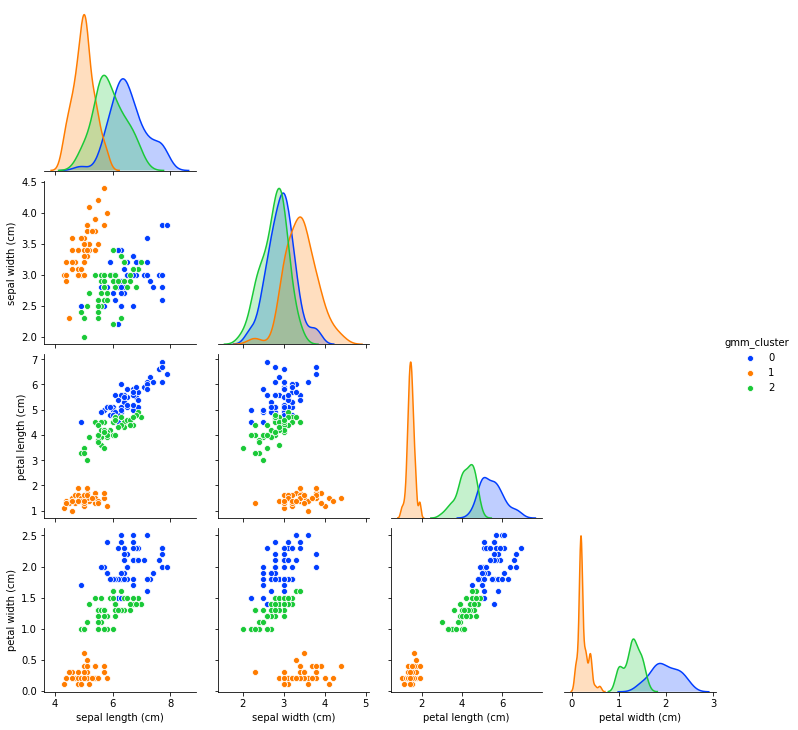

In [107]:
### 군집결과 시각화
sns.pairplot(iris.drop(['Class'], axis=1), diag_kind='kde', hue="gmm_cluster", corner=True, palette='bright')
plt.show()

In [108]:
# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = iris.groupby(['Class'])['gmm_cluster'].value_counts()
print(iris_result)

Class  gmm_cluster
0      1              50
1      2              45
       0               5
2      0              50
Name: gmm_cluster, dtype: int64


In [109]:
### predict
gmm.predict(np.array([[1, 2, 1, 2], [3, 3, 3, 3]]))
# gmm.predict_proba() -> 확률 값 제시

array([0, 0])

In [110]:
### 군집으로부터 샘플 생성 가능 -> 분포를 가정하고 있는 생성 모델의 특징
x_new, y_new = gmm.sample(6)
print(x_new, y_new)

[[ 0.90347382 -1.70967034  1.31836188  0.72409573]
 [ 1.78311353  1.04580094  1.36515985  1.32648708]
 [ 0.3800889   0.30479089  0.77001069  1.14521038]
 [ 2.93631563  0.30237085  1.67748434  1.0496748 ]
 [-1.88760012 -0.95929029 -1.24687691 -1.42413528]
 [-0.68853269 -1.96222189  0.04234782 -0.19697587]] [0 0 0 0 1 2]


In [111]:
### log-likelihood 계산
# 점수가 높을수록 밀도가 높음
gmm.score_samples(x_new)

array([-5.83793079, -2.68189108, -1.93017133, -5.31764637, -2.61731019,
       -1.97944167])

#### Best K
- BIC, AIC 등 이론적 정보 기준 사용
- 과한 클러스터를 제한하고, 데이터의 잘 맞는 모델을 찾음

In [112]:
gmm.bic(iris_scaled)

801.5535017494136

In [113]:
gmm.aic(iris_scaled)

669.0855488091784

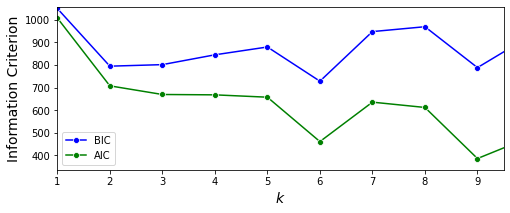

In [114]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(iris_scaled) for k in range(1, 11)]

bics = [model.bic(iris_scaled) for model in gms_per_k]
aics = [model.aic(iris_scaled) for model in gms_per_k]

plt.figure(figsize=(8, 3))
sns.lineplot(range(1, 11), bics, color='blue', marker='o', label="BIC")
sns.lineplot(range(1, 11), aics, color='green', marker='o', linestyle='dashed', label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.legend()
plt.show()

In [115]:
### Best K and covariance type
min_bic = np.infty
for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, covariance_type=covariance_type, random_state=42).fit(iris_scaled).bic(iris_scaled)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [116]:
print(best_k, best_covariance_type)

6 full


##### Outlier detection with Gaussian Mixture
- 밀도가 낮은 지역에 있는 샘플을 이상치로 생각할 수 있음
- 사용할 밀도 임곗값을 결정해야 함

In [117]:
densities = gmm.score_samples(iris_scaled)
density_threshold = np.percentile(densities, 1) # 밀도 임계값 정의
anomalies = iris_scaled[densities < density_threshold]

In [118]:
anomalies

array([[ 2.24968346, -1.05276654,  1.78583195,  1.44883158],
       [ 2.4920192 ,  1.70959465,  1.50164482,  1.05393502]])

##### Bayesian Gaussian Mixture
- 불필요한 클러스터의 가중치를 0으로 (또는 0에 가깝게) 수렴시킴
- 최적의 클러스터 개수보다 큰 컴포넌트의 개수 지정
- 클러스터 파라미터(가중치, 평균, 공분산 행렬)는 잠재 변수
    - 평균은 베타 분포, 공분산 행렬은 위샤트 분포로 추론
- weight_concentration_prior (default=1/n_components)
    - 클러스터 개수에 대한 사전 믿음으로, n_components에 설정된 군집수에 대한 규제로 사용됨
    - 작은 값이면 특정 군집의 가중치를 0에 가깝게 만들어 군집수를 줄이도록 함
    - 즉, 큰 값일 수록 n_components에 설정된 군집수가 유지되도록 함

In [119]:
from sklearn.mixture import BayesianGaussianMixture

In [120]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(iris_scaled)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [121]:
np.round(bgm.weights_, 2) # 3개의 클러스터 감지

array([0.52, 0.33, 0.01, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

### (6) SOM
- Self-Organizing Maps (Kohonen Map)
- unsupervised NN
- 완전 연결된 두 개의 layer 구성 (input layer - competitive layer)
    - 뉴런의 개수는 입력 데이터의 개수와 군집 수가 됨
    - Feed=forward flow 학습 진행
- 각 뉴런에서 거리를 구해, 승자 독점 학습

In [122]:
# !pip install minisom
from minisom import MiniSom

In [123]:
### wine data
wine.reset_index(inplace=True, drop=True)
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class,cluster
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,2


In [124]:
som_data = wine.drop(['Class', 'cluster'], axis=1)
som_target = wine['Class']

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
som_array = sc.fit_transform(som_data)

In [125]:
n_neurons = 5
m_neurons = 4

som = MiniSom(n_neurons, m_neurons, som_array.shape[1], sigma=1.5, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0)
som.random_weights_init(som_array)
som.train_random(data=som_array, num_iteration=100)

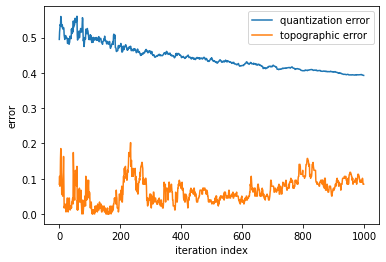

In [126]:
# iter에 따른 Error 시각화
max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(som_array))
    som.update(som_array[rand_i], som.winner(som_array[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(som_array))
    t_error.append(som.topographic_error(som_array))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

In [127]:
som.winner(som_array[0])

(0, 1)

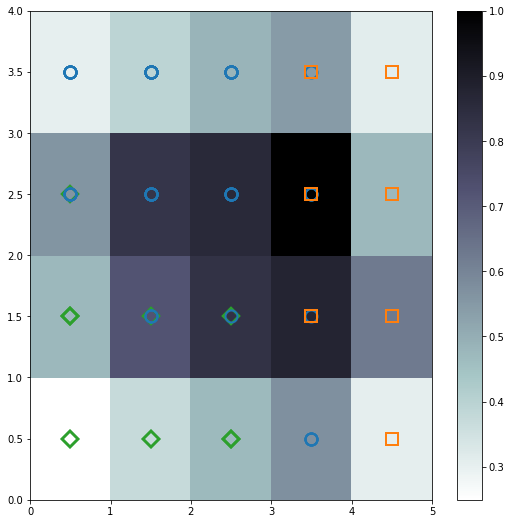

In [128]:
### SOM Visualization
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(som_array):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[som_target[cnt]-1], markerfacecolor='None', 
             markeredgecolor=colors[som_target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

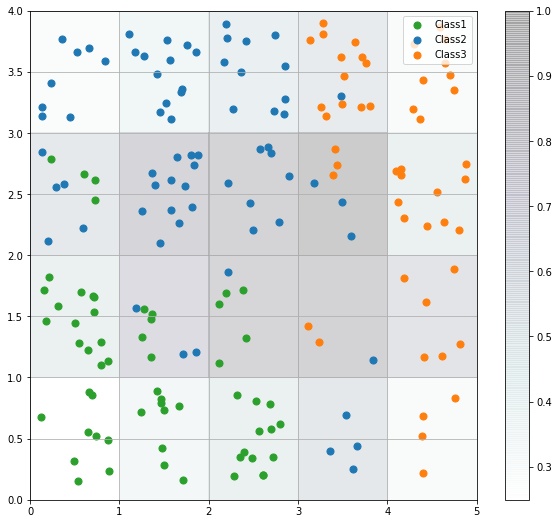

In [129]:
label_names = {0:'Class1', 1:'Class2', 2:'Class3'}

w_x, w_y = zip(*[som.winner(d) for d in som_array])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(som_target):
    idx_target = som_target==c
    plt.scatter(w_x[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) - .5) * .8,
                w_y[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) -.5) *.8, s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

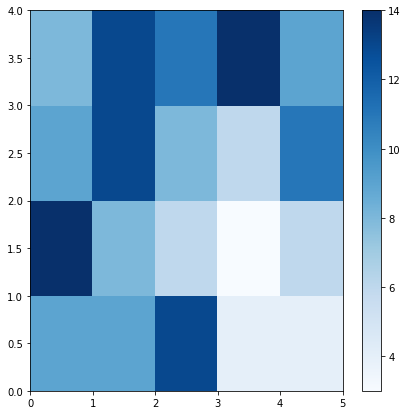

In [130]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(som_array)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [131]:
import matplotlib.gridspec as gridspec

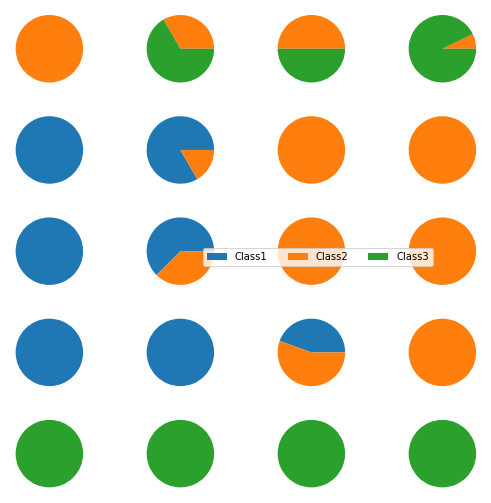

In [132]:
labels_map = som.labels_map(som_array, [label_names[t] for t in som_target.values])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[m_neurons-1-position[0], position[1]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(2, 3), ncol=3)
plt.show()

### (7) DBSCAN
- Density Based Spatial Clusting of Applications with Noise
- 군집 개수를 사전에 결정하지 않는 알고리즘
- 초기 군집 개수를 정해주지 않아도 됨
- 주변 epsilon 거리의 데이터를 군집으로 인식하고, 최소 군집 데이터 수를 정할 수 있음
    - epsilon-이웃
    - epsilon-이웃 안에 min_samples 이상의 샘플이 있다면, core instance (밀집 지역의 샘플)
    - core instance의 이웃은 동일한 클러스터
    - 클러스터에 들어가지 못하면 이상치로 판단 (-1)
- 반달 형태의 군집에 잘 적합
- 새로운 데이터의 군집 예측 불가 (예측이 필요하면 KNN Classifier 사용)

In [133]:
### iris data
feature = iris.iloc[:, :4]
feature.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [134]:
from sklearn.cluster import DBSCAN

In [135]:
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')

In [136]:
predict = pd.DataFrame(dbscan.fit_predict(feature))
predict.columns=['predict']

r = pd.concat([feature, predict],axis=1)
r['target'] = iris.Class
r.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predict,target
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0


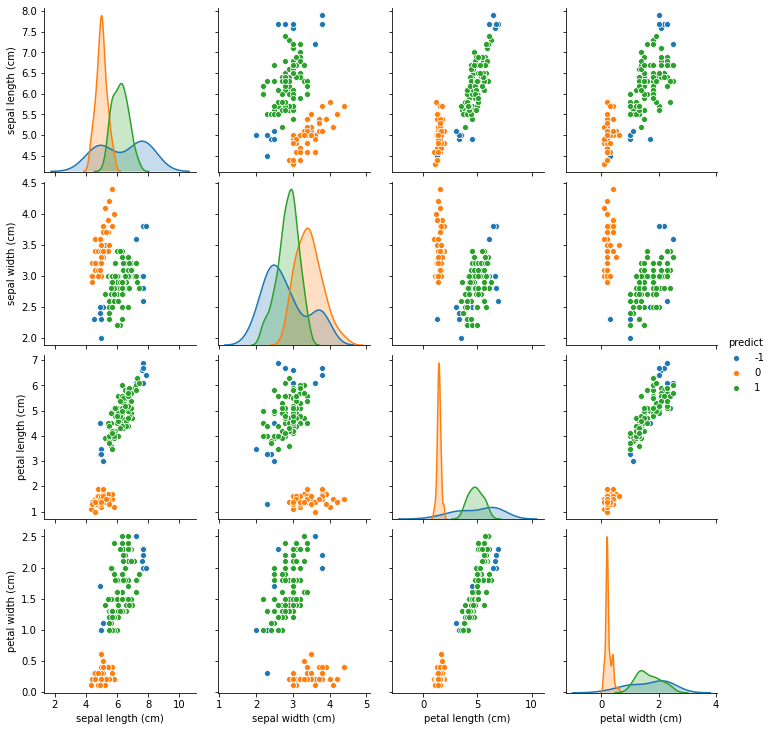

In [137]:
sns.pairplot(r.drop('target', axis=1), hue='predict')
plt.show()

In [138]:
iris_result = r.groupby(['target'])['predict'].value_counts()
iris_result

target  predict
0        0         49
        -1          1
1        1         46
        -1          4
2        1         42
        -1          8
Name: predict, dtype: int64

In [139]:
dbscan.labels_[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [140]:
dbscan.core_sample_indices_[:10] # 핵심 샘플 index

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [141]:
dbscan.components_[:3] # 핵심 샘플

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [142]:
np.unique(dbscan.labels_) # -1은 이상치

array([-1,  0,  1])

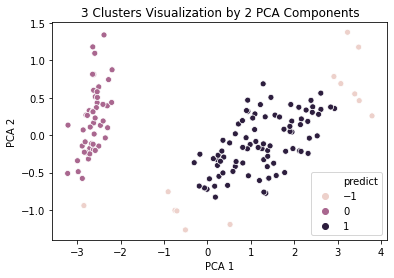

In [143]:
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(feature)

r['pca_x'] = pca_transformed[:, 0]
r['pca_y'] = pca_transformed[:, 1]

sns.scatterplot(x=r['pca_x'], y=r['pca_y'], hue=r.predict)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

target  predict
0        0         50
1        1         50
2        1         47
        -1          3
Name: predict, dtype: int64


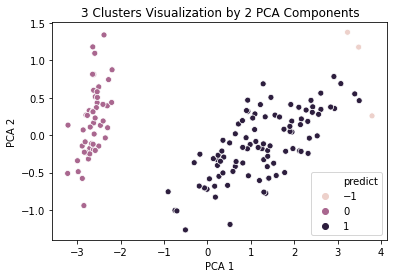

In [144]:
### eps 0.8로 상승 -> noise 감소
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(feature)

r['predict'] = dbscan_labels
r['target'] = iris.Class

iris_result = r.groupby(['target'])['predict'].value_counts()
print(iris_result)

# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(feature)

r['pca_x'] = pca_transformed[:, 0]
r['pca_y'] = pca_transformed[:, 1]

sns.scatterplot(x=r['pca_x'], y=r['pca_y'], hue=r.predict)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

target  predict
0        0         48
        -1          2
1        1         44
        -1          6
2        1         36
        -1         14
Name: predict, dtype: int64


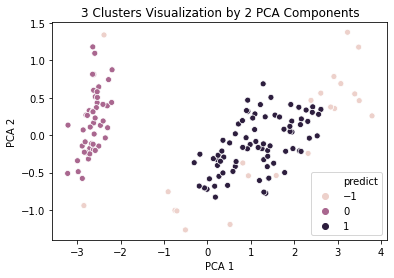

In [145]:
### min_samples 상승 -> noise 증가
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(feature)

r['predict'] = dbscan_labels
r['target'] = iris.Class

iris_result = r.groupby(['target'])['predict'].value_counts()
print(iris_result)

# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(feature)

r['pca_x'] = pca_transformed[:, 0]
r['pca_y'] = pca_transformed[:, 1]

sns.scatterplot(x=r['pca_x'], y=r['pca_y'], hue=r.predict)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

In [146]:
from sklearn.neighbors import KNeighborsClassifier

In [147]:
### KNN을 이용한 새 데이터 예측 구현
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [148]:
x_new = np.array([[-0.5, 0, 0, 1], [0, 0.5, 0, 5]])
knn.predict(x_new)
# knn.predict_proba(x_new)

array([0, 0])

In [149]:
y_dist, y_pred_idx = knn.kneighbors(x_new, n_neighbors=1) # x_new의 이웃 정보
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]

y_pred[y_dist > 0.2] = -1 # 일정 거리 이상인 경우 outlier 처리
y_pred.ravel()

array([-1, -1])

In [150]:
### Gower distance 사용
# 범주형 변수가 있는 경우
'''
import gower

distance_matrix = gower.gower_matrix(dataframe)
columns = [f'Customer_{i}' for i in range(1,11)]
distance_matrix = pd.DataFrame(distance_matrix, index=columns, columns=columns)

dbscan_cluster = DBSCAN(eps=0.3, min_samples=2, metric="precomputed")
dbscan_cluster.fit(distance_matrix)

dbscan_cluster.labels_
'''

'\nimport gower\n\ndistance_matrix = gower.gower_matrix(dataframe)\ncolumns = [f\'Customer_{i}\' for i in range(1,11)]\ndistance_matrix = pd.DataFrame(distance_matrix, index=columns, columns=columns)\n\ndbscan_cluster = DBSCAN(eps=0.3, min_samples=2, metric="precomputed")\ndbscan_cluster.fit(distance_matrix)\n\ndbscan_cluster.labels_\n'

### (8) Spectral clustering
- 샘플 사이 유사도 행렬을 받아 저차원 임베딩 (차원축소)
- 저차원 공간에서 군집 알고리즘 사용 (K-means)
- 샘플 개수가 많거나, 클러스터 크기가 다르면 성능 저하

In [151]:
from sklearn.cluster import SpectralClustering

In [152]:
x, y = make_circles(n_samples=100, shuffle=True, noise=0.05, random_state=0, factor=0.5)
cluster_df = pd.DataFrame(x, columns=['f1', 'f2'])
cluster_df['target'] = y

In [153]:
sc1 = SpectralClustering(n_clusters=2, gamma=10, random_state=42)
sc1.fit(x)

sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(x)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [154]:
np.percentile(sc1.affinity_matrix_, 95)

0.6062259936328364

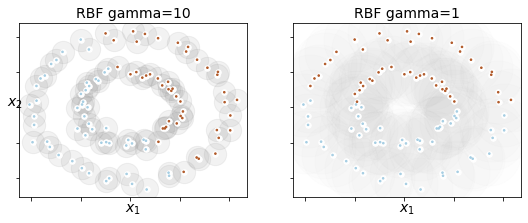

In [155]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=500, c='gray', cmap="Paired", alpha=0.1)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=30, c='w')
plt.scatter(x[:, 0], x[:, 1], marker='.', s=10, c=sc1.labels_, cmap="Paired")
plt.xlabel("$x_1$", fontsize=14)
plt.tick_params(labelbottom=False)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelleft=False)
plt.title("RBF gamma={}".format(sc1.gamma), fontsize=14)

plt.subplot(122)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=4000, c='gray', cmap="Paired", alpha=0.01)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=30, c='w')
plt.scatter(x[:, 0], x[:, 1], marker='.', s=10, c=sc2.labels_, cmap="Paired")
plt.xlabel("$x_1$", fontsize=14)
plt.tick_params(labelbottom=False)
plt.tick_params(labelleft=False)
plt.title("RBF gamma={}".format(sc2.gamma), fontsize=14)
plt.show()